# Carcrash Severity Prediction

Downloading the datasets:

Please run `wget https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/ec578660-2d3f-489d-9ba1-af0ebfc3b140/download/all-crashes-2004-2018.csv.zip`
or visit this link to get the Allegheny County crash data.

## Load Data

In [1]:
import ckanapi
import wget
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from pathlib import Path
from pprint import pprint
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [2]:
if not Path('all-crashes-2004-2018.csv.zip').exists():
    wget.download("https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/ec578660-2d3f-489d-9ba1-af0ebfc3b140/download/all-crashes-2004-2018.csv.zip")
# zf = zipfile.ZipFile('all-crashes-2004-2018.csv.zip') 
df_io = pd.read_csv('all-crashes-2004-2018.csv.zip').reset_index()

print(df_io.head())
print(len(df_io))
print(df_io.columns)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (79,183,189) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   index   CRASH_CRN  DISTRICT  CRASH_COUNTY  MUNICIPALITY POLICE_AGCY  \
0      0  2004000001        11             2          2454       02454   
1      1  2004000010        11             2          2440       02440   
2      2  2004000016        11             2          2203       02203   
3      3  2004000022        11             2          2404       02404   
4      4  2004000030        11             2          2419       02419   

   CRASH_YEAR  CRASH_MONTH  DAY_OF_WEEK  TIME_OF_DAY  ...  LANE_COUNT  \
0        2004            1            5        257.0  ...         2.0   
1        2004            1            5       1027.0  ...         2.0   
2        2004            1            5       1839.0  ...         2.0   
3        2004            1            6        914.0  ...         2.0   
4        2004            1            5       2230.0  ...         2.0   

   RDWY_ORIENT  ROAD_OWNER  ROUTE  SPEED_LIMIT  SEGMENT  OFFSET  \
0            E         2.0   2032         35.0   

The following variables will be used. Three models will be developed: one only studies the effects of environment static factor, one studies dynamic factors, and one for both factors.

In [3]:
static = ['ROAD_CONDITION', 'INTERSECT_TYPE', 'LANE_CLOSED', 'TIME_OF_DAY', 'SPEED_LIMIT', 'ILLUMINATION']
dynamic = ['MOTORCYCLE_COUNT', 'HEAVY_TRUCK_COUNT', 'HAZARDOUS_TRUCK', 'AUTOMOBILE_COUNT', 'SCH_BUS_IND', 'WEATHER']
label = ['PERSON_COUNT', 'FATAL_COUNT', 'INJURY_COUNT', 'MAX_SEVERITY_LEVEL', 'MAJOR_INJURY']
categorical = ['ROAD_CONDITION', 'INTERSECT_TYPE', 'LANE_CLOSED', 'ILLUMINATION', 'HAZARDOUS_TRUCK', 'SCH_BUS_IND', 'WEATHER']
gaussian = ['TIME_OF_DAY', 'SPEED_LIMIT', 'MOTORCYCLE_COUNT', 'HEAVY_TRUCK_COUNT', 'AUTOMOBILE_COUNT']
data = static + dynamic

## Data Cleanup

In [4]:
#clean sch_bus_ind y/n to integer 0,1

def type_boolean(c):
    if c == "Y": return 1
    elif c == "N": return 0
    # elif c == "nan": return np.nan
    else:
        return np.nan
    # raise ValueError(c)

def ROAD_CONDITION(c): # 8 is other 9 is unknown, 1,7->2, 3->4, 4->3, 5,6->5, 2,8,9->nan
    if c == 1 or c == 7:
        return 2
    elif c == 3:
        return 4
    elif c == 4:
        return 3
    elif c == 5 or c == 6:
        return 5
    else:
        return np.nan

def INTERSECT_TYPE(c): # 10 is other 99 is unknown
    if c <= 9:
        return c
    else:
        return np.nan

def ILLUMINATION(c):
    if c <= 6:
        return c
    else:
        return np.nan
    
def WEATHER(c):
    if c <= 7:
        return c
    else:
        return np.nan
    
def TIME(c): # extract only the hour
    if c <= 2500:
        return c // 100
    else:
        return np.nan

# clean data
df_io['SCH_BUS_IND'] = df_io['SCH_BUS_IND'].apply(type_boolean)
df_io['ROAD_CONDITION'] = df_io['ROAD_CONDITION'].apply(ROAD_CONDITION)
df_io['INTERSECT_TYPE'] = df_io['INTERSECT_TYPE'].apply(INTERSECT_TYPE)
df_io['ILLUMINATION'] = df_io['ILLUMINATION'].apply(ILLUMINATION)
df_io['WEATHER'] = df_io['WEATHER'].apply(WEATHER)
df_io['TIME_OF_DAY'] = df_io['TIME_OF_DAY'].apply(TIME)

## Data Visualization

Before we do any machine learning on this dataset, we perform some visualizations to get some insights into this dataset. 

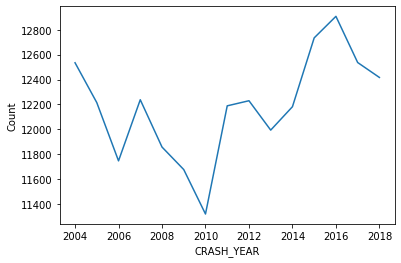

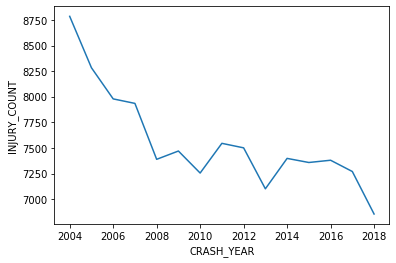

In [5]:
# total number of crashes over years
df = pd.DataFrame({'CRASH_YEAR': df_io['CRASH_YEAR'], 'Count': np.ones(len(df_io))})
df = df.groupby('CRASH_YEAR').count().reset_index()
sns.lineplot(x='CRASH_YEAR', y='Count', data=df)

# total injuries count over years
plt.figure()
df = df_io.groupby('CRASH_YEAR').sum().reset_index()
sns.lineplot(x='CRASH_YEAR', y='INJURY_COUNT', data=df)

Thus, the number of crashes fluctuates between yeras, but the total number of injuries decreases. We may also want to see which months have greater crashes and whether there's a change in alcohol related crashing for different years. 

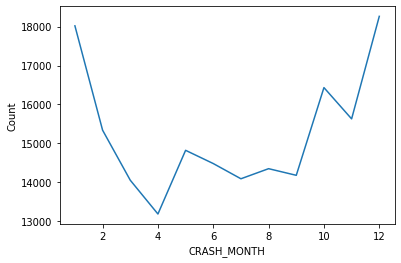

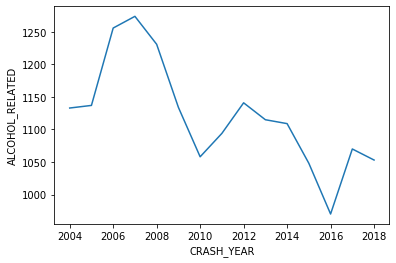

In [13]:
# crash by month
plt.figure()
df = pd.DataFrame({'CRASH_MONTH': df_io['CRASH_MONTH'], 'Count': np.ones(len(df_io))})
df = df.groupby('CRASH_MONTH').count().reset_index()
sns.lineplot(df['CRASH_MONTH'], df['Count'])

# alcohol related crashing
plt.figure()
df = df_io.groupby('CRASH_YEAR').sum().reset_index()
sns.lineplot(df['CRASH_YEAR'], df['ALCOHOL_RELATED'])

As shown in this barplot, January and December have greater number of crashes than the rest of the months throughout a year. Additionally, alcohol related crashing is fluctuating but overall decreasing rom 2004 to 2018. 

Next, we want to see if certain variables could help us predict certain metrics. We first start by observing the effect of some of the static environmental and dyanmic variables on the metric MAX_SEVERITY_LEVEL. 

<Figure size 432x288 with 0 Axes>

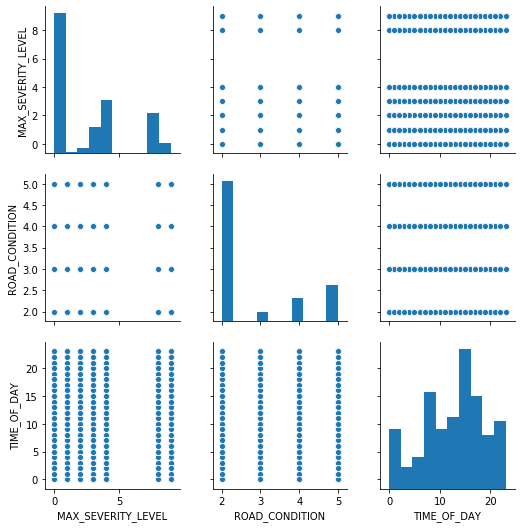

In [16]:
def scatterplot_matrix_static(metric):
    plt.figure()
    df = pd.DataFrame({metric: df_io[metric],
                       'ROAD_CONDITION': df_io['ROAD_CONDITION'],
                       'TIME_OF_DAY': df_io['TIME_OF_DAY'],
                      })
    sns.pairplot(df)

# scatterplot matrix to assess max severity level (static)
scatterplot_matrix_static('MAX_SEVERITY_LEVEL')

<Figure size 432x288 with 0 Axes>

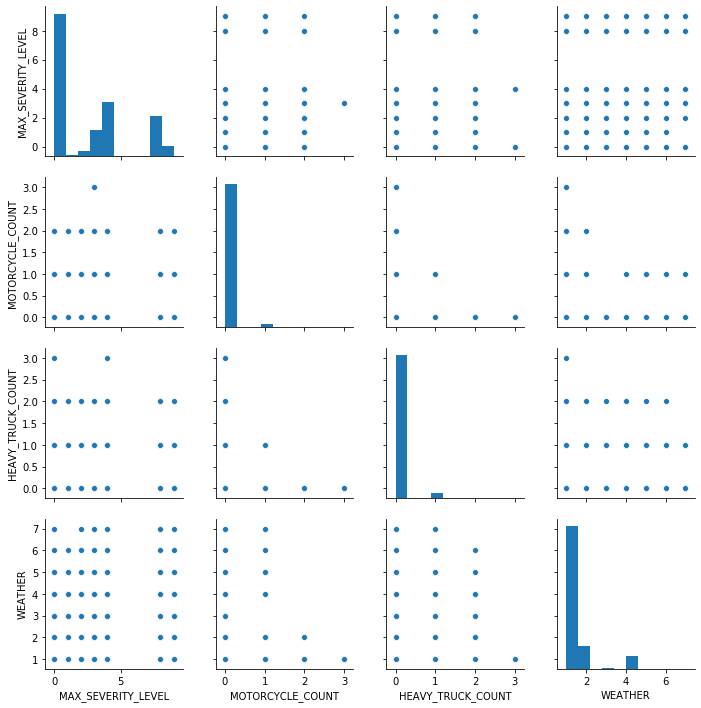

In [18]:
def scatterplot_matrix_dynamic(metric):
    plt.figure()
    df = pd.DataFrame({metric: df_io[metric],
                       'MOTORCYCLE_COUNT': df_io['MOTORCYCLE_COUNT'],
                       'HEAVY_TRUCK_COUNT': df_io['HEAVY_TRUCK_COUNT'],
                       'WEATHER': df_io['WEATHER'],
                      })
    sns.pairplot(df)

# scatterplot matrix to assess max severity level (static)
scatterplot_matrix_dynamic('MAX_SEVERITY_LEVEL')

Finally, before analysis, we drop out the unnecessary information and we are ready for analysis

In [19]:
# drop col that will not be used
for col in df_io.columns:
    if col not in static and col not in dynamic and col not in label:
        df_io.drop(col, axis = 1, inplace = True)

# drop rows contain nan
df_io = df_io.dropna()
df_io = df_io.astype("int64")
df_io[categorical] = df_io[categorical].astype("object")
#print(df_io[15:25])
# group data into dataset/label
df_data = df_io[data].copy()
df_label = df_io[label].copy()
print(df_data.info())
print(df_label.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43610 entries, 1 to 180963
Data columns (total 12 columns):
ROAD_CONDITION       43610 non-null object
INTERSECT_TYPE       43610 non-null object
LANE_CLOSED          43610 non-null object
TIME_OF_DAY          43610 non-null int64
SPEED_LIMIT          43610 non-null int64
ILLUMINATION         43610 non-null object
MOTORCYCLE_COUNT     43610 non-null int64
HEAVY_TRUCK_COUNT    43610 non-null int64
HAZARDOUS_TRUCK      43610 non-null object
AUTOMOBILE_COUNT     43610 non-null int64
SCH_BUS_IND          43610 non-null object
WEATHER              43610 non-null object
dtypes: int64(5), object(7)
memory usage: 4.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43610 entries, 1 to 180963
Data columns (total 5 columns):
PERSON_COUNT          43610 non-null int64
FATAL_COUNT           43610 non-null int64
INJURY_COUNT          43610 non-null int64
MAX_SEVERITY_LEVEL    43610 non-null int64
MAJOR_INJURY          43610 non-null int64


## Model

In [21]:
class GaussianPredictor:
    
    """ Feature predictor for a normally distributed real-valued, continuous feature.

        attr:
            k : int -- number of classes
            mu : np.ndarray[k] -- vector containing per class mean of the feature
            sigma : np.ndarray[k] -- vector containing per class std. deviation of the feature
    """
    
    def __init__(self, k):
        """ constructor

        args : k -- number of classes
        """
        self.k = k
        self.mu = np.zeros(k)
        self.sigma = np.zeros(k)
        pass

    def fit(self, x, y):
        """update predictor statistics (mu, sigma) for Gaussian distribution

        args:
            x : pd.Series -- feature values
            y : np.Series -- class labels
            
        return : GaussianPredictor -- return self for convenience
        
        """
        y=np.array(y)
        x=np.array(x)
    
        for i in range(self.k):
            ybools = (y==i)
            given_i = np.extract(ybools,x)
            self.mu[i]=given_i.mean()
            self.sigma[i]=np.sqrt(given_i.var())
        return self
            
    def partial_log_likelihood(self, x):
        """ log likelihood of feature values x according to each class

        args:
            x : pd.Series -- feature values

        return: np.ndarray[self.k, len(x)] : log likelihood for this feature for each class
        """
        logpdfs = np.zeros((self.k,len(x)))
        for i in range(self.k):
            logpdfs[i]=stats.norm(loc=self.mu[i],scale=self.sigma[i]).logpdf(x)
        return logpdfs

In [22]:
class CategoricalPredictor:
    """ Feature predictor for a categorical feature.

        attr: 
            k : int -- number of classes
            p : Dict[feature_value, np.ndarray[k]] -- dictionary of vectors containing per-class probability of a feature value;
    """
    
    def __init__(self, k):
        """ constructor

        args : k -- number of classes
        """
        self.k=k

    def fit(self, x, y, alpha=1.):
        """ initializes the predictor statistics (p) for Categorical distribution
        
        args:
            x : pd.Series -- feature values
            y : pd.Series -- class labels
        
        kwargs:
            alpha : float -- smoothing factor

        return : CategoricalPredictor -- returns self for convenience:
        """
        y=np.array(y)
        x=np.array(x)
        self.p = {}
        for char in set(x):
            self.p[char]=np.zeros(self.k)
            
        
        for i in range(self.k):
            # n=sum([1 for j in range(len(y)) if y[j] == i])
            ybools= (y==i)
            
            n=np.sum( ybools )
            for char in set(x):
                xbools= (x == char)
                # nj=sum([1 for j in range(len(y)) if x[j] == char and y[j] == i ])
                nj = np.sum(np.logical_and(xbools,ybools))
                (self.p[char])[i] = (nj + alpha)/ (n+len(set(x))*alpha)
        return self

    def partial_log_likelihood(self, x):
        """ log likelihood of feature values x according to each class

        args:
            x : pd.Series -- vector of feature values

        return : np.ndarray[self.k, len(x)] -- matrix of log likelihood for this feature
        """
        like = np.zeros((self.k,len(x)))
        
        for i in range(self.k):
            for j,char in enumerate(x):
                like[i][j]=np.log(self.p[char][i])
        return like

In [23]:
# working
class NaiveBayesClassifier:
    """ Naive Bayes classifier for a mixture of continuous and categorical attributes.
        We use GaussianPredictor for continuous attributes and CategoricalPredictor for categorical ones.
        
        attr:
            predictor : Dict[column_name,model] -- model for each column
            log_prior : np.ndarray -- the (log) prior probability of each class
    """

    def __init__(self, df, label, alpha=1.):
        """initialize predictors for each feature and compute class prior
        
        args:
            df : pd.DataFrame -- processed dataframe, without any missing values.
        
        kwargs:
            alpha : float -- smoothing factor for prior probability
        """
        k = max(label)+1
        self.log_prior = np.zeros(k)
        n = len(label)
        for i in range(k):
            ybools= (label==i)          
            nt=np.sum( ybools )
            self.log_prior[i] = np.log( (nt+alpha)/(n+(k*alpha)))
        
        self.predictor = dict()
        types = dict(df.dtypes)
        for key in types:
            if key != "label" and key!= "index":
                if str(types[key])=="int64":
                    self.predictor[key]=GaussianPredictor(k).fit(df[key],label)
                elif str(types[key])=="object":
                    self.predictor[key]=CategoricalPredictor(k).fit(df[key],label)
                else:
                    raise TypeError
                    
        self.k=k            
        pass

    def log_likelihood(self, x):
        """log_likelihood for input instances from log_prior and partial_log_likelihood of feature predictors

        args:
            x : pd.DataFrame -- processed dataframe (ignore label if present)

        returns : np.ndarray[num_classes, len(x)] -- array of log-likelihood
        """
        like = np.array(([self.log_prior,]*len(x))).transpose()
        
        for key in self.predictor:
            model = self.predictor[key]
            z= model.partial_log_likelihood(x[key])
            like +=z
            
        return like           

    def predict(self, x):
        """predicts label for input instances, breaks ties in favor of the class with lower id.

        args:
            x : pd.DataFrame -- processed dataframe (ignore label if present)

        returns : np.ndarray[len(x)] -- vector of class labels
        """
        pred = np.argmax(self.log_likelihood(x),axis = 0)
        return pred


### Label normalization

In [24]:
def label_normalization(label, label_test):
    labellist = pd.Series(np.append(label,label_test)).unique()
    labellist.sort()
    revdic = dict()
    for i,z in enumerate(labellist):
        revdic[z] = i
    f = (lambda s: revdic[s])
    return np.array(list(map(f, label))),np.array(list(map(f, label_test)))

### Accuracy estimate

In [25]:
def cal_accuracy(y_pred, y_test):
    correct_counter = 0
    total = len(y_test)
    if total != len(y_pred):
        print("param size not match.")
        
    for idx in range(total):
        if (int)(y_pred[idx]) == (int)(y_test[idx]):
            correct_counter += 1
            
    return correct_counter / total

def f1(pred, ground):
    """ evaluates a classifier based on a supplied validation data

    args:
        pred: numpy.ndarray(bool) -- predictions
        ground: numpy.ndarray(bool) -- known ground-truth values
    
    return : double -- the F1 score of the predictions
    """
    pred = np.array(pred, dtype=bool)
    ground = np.array(ground, dtype=bool)
    realT = sum(ground)
    predT = sum(pred)
    bothT = float(sum([1 for i in range(ground.shape[0]) if pred[i] and ground[i]]))
    precision = bothT/predT
    recall = bothT/realT
    print("precision and recal in f1:", precision, recall)
    return 2*(precision*recall)/(precision+recall)

### Define a function to split, train, pred and test data

In [26]:
def train(data, label, s, verbal, a=1.):
    x_train, x_test, y_train, y_test = train_test_split(data, df_io[label], test_size=s, random_state=42)
    y_train, y_test = label_normalization(y_train, y_test)
    classifier = NaiveBayesClassifier(x_train, pd.Series(y_train), a)
    y_pred = classifier.predict(x_test)
    c = collections.Counter(y_pred)
    d = collections.Counter(y_test)
    
    if verbal:
        print(label, "pred counter: ", c)
        print(label, "test counter: ", d)
        
    a = cal_accuracy(y_pred, y_test)
    print(label, "accuracy: ", a)
    return (classifier, a)

In [ ]:
def train_all(data, metrics, s, verbal=False):
    classifiers = []
    for (m, a) in metrics:
        classifier = train(data, m, s, verbal, a)
        classifiers.append(classifier)
        
    return classifiers

metrics = [('MAJOR_INJURY', 1.),
           ('MAX_SEVERITY_LEVEL', 1.), 
           ('PERSON_COUNT', 1.), 
           ('FATAL_COUNT', 1.), 
           ('INJURY_COUNT', 0.001)
          ]
s = 0.33

print("******** train ENVIRONMENT STATIC factors **********")
classifier_s = train_all(df_io[static].copy(), metrics, s)

print("\n******** train DYNAMIC factors ********")
classifier_d = train_all(df_io[dynamic].copy(), metrics, s)

print("\n******** train COMBINED factors ********")
classifier_c = train_all(df_io[data].copy(), metrics, s)


******** train ENVIRONMENT STATIC factors **********
MAJOR_INJURY accuracy:  0.9872846025569761
MAX_SEVERITY_LEVEL accuracy:  0.5640633685380767


In [29]:
# select the best classifier for each metric
classifiers = []
for i in range(0, len(metrics)):
    (c_s, a_s) = classifier_s[i]
    (c_d, a_d) = classifier_d[i]
    (c_c, a_c) = classifier_c[i]
    max_accuracy = max(a_s, a_d, a_c)
    if a_s == max_accuracy: classifiers.append((c_s, max_accuracy))
    elif a_d == max_accuracy: classifiers.append((c_d, max_accuracy))
    else: classifiers.append((c_c, max_accuracy))
        
print(classifiers)

[(<__main__.NaiveBayesClassifier object at 0x11fad18d0>, 0.9872846025569761), (<__main__.NaiveBayesClassifier object at 0x11fefe710>, 0.5640633685380767), (<__main__.NaiveBayesClassifier object at 0x11b2e0590>, 0.0029182879377431907), (<__main__.NaiveBayesClassifier object at 0x11d447550>, 0.9955530850472485), (<__main__.NaiveBayesClassifier object at 0x11f59a510>, 0.0048638132295719845)]


## Real-Time Severity Prediction